# Student Name   : Yash Singh Pathania 
# Student Number : 24204265
# Note : Print Statements Are for debugging/understanding can be ignored 


# Deep Feedforward Neural Network #

Objectives: built and train a deep layer feedforward neural network building on the single feedfoward neural network implementation of the previous session notebook.

> **Instructions:** ensure your Python environment is setup with the following additional packages: 
>
> - `t4utils.py` contains unit tests to check your code

**Notation:** superscript $[k]$ refers to quantities associated with the $k$-th layer.

<img src="figs/deepnetwork.png" style="width:800px;">

In [202]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
import h5py
import t4utils as t4

%matplotlib inline
np.set_printoptions(precision=5, suppress=True)

Summary of steps to implement a deep neural network model:

1. Initialize the parameters of a $K$-layer neural network.
2. Implement the forward propagation:
    - compute linear component $z^{[k]}=a^{[k-1]} W^{[k]} + b^{[k]}$
    - compute activation $a^{[k]} = g(z^{[k]})$, where $g(\cdot)$ is the layer non-linearity (activation function). We'll use both ReLU and sigmoid.
    - combine $K-1$ ReLU layers with a final sigmoid layer ($K$ layer in total)
    - compute all layer outputs
    - evaluate loss from final layer activation
3. Implement the backward propagation:
    - compute the gradients for the linear component and the non-linear activation function
    - perform backprop on sigmoid layer followed by $K-1$ ReLU layers
    - evaluate gradients for all parameters $W^{[k]}, b^{[k]}$
4. Update parameters using learning rate

To implement our learning algorithm, we will associate a backprop module for every forward function. At every step of your 
forward evaluation, we will store results in a cache required to compute gradients during backprop. As a result, training a network using backprop requires about twice more memory than inference. With deep learning frameworks, your generally describe your network as graph and differentiation is performed automatically for training model parameters.

## A. Load Dataset and Initialise Model ##

First, let's generate a dataset to work on. We will use the `catsvsnoncats` image dataset used in the logistic regression notebook.

In [203]:
def load_dataset(filepath='datasets/catsvsnoncats.h5'):
    """
    Load and pre-process dataset
    
    Arguments:
    filepath -- string, dataset path

    Returns:
    (X_train, Y_train), (X_test, Y_test), classes -- training and test datasets
    """

    h5file = h5py.File(filepath, "r")
    X_train = np.array(h5file["X_train"][:])
    Y_train = np.array(h5file["Y_train"][:])
    X_test = np.array(h5file["X_test"][:])
    Y_test = np.array(h5file["Y_test"][:])
    classes = np.array(h5file["Classes"][:]) 
    h5file.close()

    # Reshape and scale datasets containing N_train and N_test mages such that
    # X_train.shape = (n_train, W * H * 3)
    # Y_train.shape = (n_train, 1)
    # X_test.shape = (n_test, W * H * 3)
    # X_test.shape = (n_test, 1)
    # Scale X_train and X_test from range {0..255} to (0,1)
    ### INPUT YOUR CODE HERE ### (4 lines)
    X_train = X_train.reshape(X_train.shape[0], -1) / 255
    X_test  = X_test.reshape(X_test.shape[0], -1) / 255
    Y_train = Y_train.reshape(Y_train.shape[0], 1)
    Y_test  = Y_test.reshape(Y_test.shape[0], 1)
    ### END OF YOUR CODE SEGMENT ###

    print (' After X_trian') # Just for debugging 
    return (X_train, Y_train), (X_test, Y_test), classes

Let's now configure our model topology i.e. K-1 ReLU activated layers and one final sigmoid activated layer. Initialise bias to zeros and weights from $\mathcal{N}(0,\sigma)$ with $\sigma = 1 /\sqrt{n_h^{[k]}}$ where $n_h^{[k]}$ is number of units in the $k$-th layer.

The number of units of the first layer is determined by the number of features of our dataset, $x$. Similarly the number of units of the final output layer is determined by the dimension of $y$. The number of units for the remaining $K-1$ hidden layers is specified as an array of integers.

> <font color='darkgreen'>**Exercise 1:**</font> Setup the model topology

In [204]:
def model_config(X, Y, n_h=[128, 64, 16, 8]):
    """
    Arguments:
    X -- n data samples, shape = (n, n_x)
    Y -- ground truth label, column vector of shape (n, n_y)
    n_h -- array with number of units in hidden layers, size K-1
    
    Returns:
    params -- dictionary containing initialised model parameters
        W1 -- initialised weight matrix of shape (n_x, n_h1)
        b1 -- initialised bias vector of shape (1, n_h1)
        ...
        Wk -- initialised weight matrix of shape (n_hk-1, n_hk)
        bk -- initialised bias vector of shape (1, n_hk)
        ...
        WK -- initialised weight matrix of shape (n_hK-1, n_y)
        bK -- initialised bias vector of shape (1, n_y)
    """
    
    ### INPUT YOUR CODE HERE ### (2 lines)
    n_x = X.shape[1] # size of input layer
    n_y = Y.shape[1] # size of output layer
    ### END OF YOUR CODE SEGMENT ###  
    
    dims = sum([[n_x], n_h, [n_y]], [])
    K = len(dims) # number of network layers

    params = {}
    
    for k in range(1, K):
        ### INPUT YOUR CODE HERE ### (2 lines)
        params['W{}'.format(k)] = np.random.randn(dims[k - 1], dims[k]) * 1/np.sqrt(dims[k-1])  # Initialize weights with small random values
        params['b{}'.format(k)] = np.zeros((1, dims[k]))  # Initialize biases to zeros
        ### END OF YOUR CODE SEGMENT ###                                            
        assert(params['W{}'.format(k)].shape == (dims[k - 1], dims[k]))
        assert(params['b{}'.format(k)].shape == (1, dims[k]))

    assert(X.shape[0] == (Y.shape[0]))
    return params

In [205]:
X, Y, n_h = t4.model_config_test()
params = model_config(X, Y, [3])
for k in range(1, len(params) // 2 + 1):
    print("W{} = {}".format(k, params['W{}'.format(k)]))
    print("b{} = {}".format(k, params['b{}'.format(k)]))

W1 = [[ 0.9195  -0.21968  0.58   ]
 [-0.28855 -0.51552 -0.41944]
 [ 0.15847  0.17663  0.75786]
 [-0.18893 -0.54634 -0.32417]]
b1 = [[0. 0. 0.]]
W2 = [[ 0.85447 -1.2155 ]
 [ 0.13204  0.20821]
 [-0.83132 -0.38261]]
b2 = [[0. 0.]]


# use np.random with multiplication wiht 0.1 to keep them small for initial input 

> ***Expected Output:***
> 
> ```
> W1 = [[ 0.9195  -0.21968  0.58   ]
>       [-0.28855 -0.51552 -0.41944]
>       [ 0.15847  0.17663  0.75786]
>       [-0.18893 -0.54634 -0.32417]]
> b1 = [[0. 0. 0.]]
> W2 = [[ 0.85447 -1.2155 ]
>       [ 0.13204  0.20821]
>       [-0.83132 -0.38261]]
> b2 = [[0. 0.]]
> ```

***

## B. Forward Propagation ##

We will now implement the forward propagation for the linear component of the $k$-th layer $z_k = a^{[k-1]} W^{[k]} + b^{[k]}$ and its activation $a^{[k]} = g(z^{[k]})$, where $g(\cdot)$ is either the ReLU or the sigmoid function. Note that $a^{[0]} = x$. We should also return a cache for the backward propagation.

For $n$ samples stacked in the rows of a input matrix $X$, the linear and activation parts are given by $Z_k = A^{[k-1]} W^{[k]} + b^{[k]}$ and $A^{[k]} = g(Z^{[k]})$

> <font color='darkgreen'>**Exercise 2:**</font> Implement forward propagation for the linearity and both activation functions.

In [206]:
# Forward propagation for linearity
def linear_fwd(W, b, A):
    """
    Linearity

    Arguments:
    W -- weight matrix, shape (n_hk-1, n_hk)
    b -- bias row vector, shape (1, n_hk)
    A -- input, shape (n, n_hk-1)

    Returns:
    Z -- linear output, shape (n, n_hk)
    cache -- dictionary for back propagation
        W -- weight matrix
        b -- bias row vector
        A_prev -- input
    """
    
    ### INPUT YOUR CODE HERE ### (2 lines)
    Z = np.dot(A, W) + b
    cache = {"W": W, "b": b, "A_prev": A}
    ### END OF YOUR CODE SEGMENT ###  
    
    assert(Z.shape == (A.shape[0], W.shape[1]))
    return Z, cache

# Forward propagation for sigmoid non-linearity
def sigmoid_fwd(Z):
    """
    Sigmoid activation
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(Z), same shape as Z
    cache -- dictionary for backpropagation
        Z -- activation's input
    """

    ### INPUT YOUR CODE HERE ### (2 lines)
    A = 1 / (1 + np.exp(-Z))  # Calculate sigmoid activation
    cache = {"Z": Z}          # Store Z for backpropagation
    ### END OF YOUR CODE SEGMENT ###  
    
    assert(A.shape == Z.shape)
    return A, cache

# Forward propagation for ReLU non-linearity
def relu_fwd(Z):
    """
    RELU activation

    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of ReLU(Z), same shape as Z
    cache -- dictionary for backpropagation
        Z -- activation's input
    """
    
    ### INPUT YOUR CODE HERE ### (2 lines)
    A = np.maximum(Z, 0)      # Calculate ReLU activation 
    cache = {"Z": Z}          # Store Z for backpropagation
    ### END OF YOUR CODE SEGMENT ###  

    assert(A.shape == Z.shape)
    return A, cache


In [207]:
W, b, A = t4.linear_fwd_test()
Z, cache = linear_fwd(W, b, A)
print("Z.T = {}".format(Z.T))
A, cache = relu_fwd(Z)
print("A.T = ReLU(Z.T) = {}".format(A.T))
A, cache = sigmoid_fwd(Z)
print("A.T = sigmoid(Z.T) = {}".format(A.T))

Z.T = [[0.71591 1.45199]]
A.T = ReLU(Z.T) = [[0.71591 1.45199]]
A.T = sigmoid(Z.T) = [[0.67171 0.8103 ]]


> ***Expected Output:***
> 
> ```
> Z.T = [[0.71591 1.45199]]
> A.T = ReLU(Z.T) = [[0.71591 1.45199]]
> A.T = sigmoid(Z.T) = [[0.67171 0.8103 ]]
> ```


> <font color='darkgreen'>**Exercise 3:**</font> Implement the single layer forward propagation<br>
> Combine the forward modules to compute a single layer forward propagation $A^{[k]} = g(Z^{[k]}) = g(A^{[k-1]} W^{[k]})$, where $g(\cdot)$ is the non-linearity (either ReLU or Sigmoid). Also return the cache for the layer's backpropagation.

In [208]:
# Single layer forward propagation for 
def singlelayer_fwd(W, b, A_prev, non_linearity='ReLU'):
    """
    Single layer forward propagation (linear + non-linearity)

    Arguments:
    W -- weight matrix, shape (n_hk-1, n_hk)
    b -- bias row vector, shape (1, n_hk)
    A_prev -- input, shape (n, n_hk-1)
    non_linearity -- string ('ReLU' or 'Sigmoid') activation for layer
    
    Returns:
    A -- output of g(A_prev @ W + b), shape (n, n_hk)
    cache -- dictionary for backprop
        LINEAR -- dictionary linear cache
        ACTIVATION -- dictionary activation cache        
    """
    
    ### INPUT YOUR CODE HERE ### (1 line)
    Z, linear_cache = linear_fwd(W, b, A_prev)
    ### END OF YOUR CODE SEGMENT ### 
    
    if non_linearity == 'ReLU':
        ### INPUT YOUR CODE HERE ### (1 line)
        A, activation_cache = relu_fwd(Z)
        ### END OF YOUR CODE SEGMENT ### 
    elif non_linearity == 'Sigmoid':
        ### INPUT YOUR CODE HERE ### (1 line)
        A, activation_cache = sigmoid_fwd(Z)
        ### END OF YOUR CODE SEGMENT ###
    
    assert(A.shape == (A_prev.shape[0], W.shape[1]))
    return A, {'LINEAR': linear_cache, 'ACTIVATION': activation_cache}

In [209]:
W, b, A_prev = t4.singlelayer_fwd_test()
A, cache = singlelayer_fwd(W, b, A_prev, 'Sigmoid')
print("A_Sigmoid.T = {}".format(A.T))
print("cache = {}".format(cache))
A, cache = singlelayer_fwd(W, b, A_prev, 'ReLU')
print("A_ReLU.T = {}".format(A.T))
print("cache = {}".format(cache))

A_Sigmoid.T = [[0.67171 0.8103 ]]
cache = {'LINEAR': {'W': array([[ 0.57376],
       [ 0.28773],
       [-0.23563]]), 'b': array([[0.95349]]), 'A_prev': array([[-0.21768,  0.82146,  1.48128],
       [ 1.33186, -0.36187,  0.68561]])}, 'ACTIVATION': {'Z': array([[0.71591],
       [1.45199]])}}
A_ReLU.T = [[0.71591 1.45199]]
cache = {'LINEAR': {'W': array([[ 0.57376],
       [ 0.28773],
       [-0.23563]]), 'b': array([[0.95349]]), 'A_prev': array([[-0.21768,  0.82146,  1.48128],
       [ 1.33186, -0.36187,  0.68561]])}, 'ACTIVATION': {'Z': array([[0.71591],
       [1.45199]])}}


> ***Expected Output:***
>
> ```
> A_Sigmoid.T = [[0.67171 0.8103 ]]
> cache = {'LINEAR': {'W': array([[ 0.57376],
>                                 [ 0.28773],
>                                 [-0.23563]]), 
>                     'b': array([[0.95349]]), 
>                     'A_prev': array([[-0.21768,  0.82146,  1.48128],
>                                      [ 1.33186, -0.36187,  0.68561]])}, 
>                     'ACTIVATION': {'Z': array([[0.71591],
>                                                [1.45199]])}}
> A_ReLU.T = [[0.71591 1.45199]]
> cache = {'LINEAR': {'W': array([[ 0.57376],
>                                 [ 0.28773],
>                                 [-0.23563]]), 
>                     'b': array([[0.95349]]), 
>                     'A_prev': array([[-0.21768,  0.82146,  1.48128],
>                                      [ 1.33186, -0.36187,  0.68561]])},
>                     'ACTIVATION': {'Z': array([[0.71591],
>                                               [1.45199]])}}
> ```

***

Create a $K$-layer deep model by stacking single layer forward propagation. The first $K-1$ layers use the ReLU non-linearity for their activation function and the sigmoid function is applied on the final layer.

The loss for $n_{train}$ stacked examples is given by:
$$\mathcal{L}(Y, A^{[K]}) = -\frac{1}{n_{train}}\left(
Y^T\, \log A^{[K]} + (1-Y)^T\,\log(1-A^{[K]})
\right)$$

where $A^{[K]}$ is the final layer activation.

> <font color='darkgreen'>**Exercise 4:**</font> Implement the $K$-layer forward propagation and compute the loss<br>
>
> **Note** that it is not possible to vectorise the network depth and a loop must be used. This is the only loop in our model. Keep a record of the caches for all $K$ layers in an python list (use `list.append(element)`).

In [210]:
# Forward propagation (inference)
def forward_prop(params, X, Y=None):
    """
    Compute the layer activations and loss if needed

    Arguments:
    params -- dictionary containing model parameters
        W1 -- initialised weight matrix of shape (n_x, n_h1)
        b1 -- initialised weight matrix of shape (1, n_h1)
        ...
        WK -- initialised weight matrix of shape (n_hK-1, n_y)
        bK -- initialised weight matrix of shape (1, n_y)
    X -- n data samples, shape = (n, n_x)
    Y -- optional argument, ground truth label, column vector of shape (n, n_y)

    Returns:
    A -- final layer output (activation value) 
    loss -- cross-entropy loss or NaN if Y=None
    caches -- array of caches for the K layers
    """
    
    caches = []
    K = len(params) // 2  # Integer division to get the number of layers
    A = X
    
    # K-1 [Linear->ReLU] layer
    for k in range(1, K):
        A_prev = A
        ### INPUT YOUR CODE HERE ### (3 lines)
        W = params['W{}'.format(k)]
        b = params['b{}'.format(k)]
        A, cache = singlelayer_fwd(W, b, A_prev, non_linearity='ReLU')
        ### END OF YOUR CODE SEGMENT ### 
        caches.append(cache)

    # 1 [Linear->Sigmoid] layer
    A_prev = A
    ### INPUT YOUR CODE HERE ### (3 lines)
    W = params['W{}'.format(K)]  # Access the last layer's weights
    b = params['b{}'.format(K)]  # Access the last layer's bias
    A, cache = singlelayer_fwd(W, b, A_prev, non_linearity='Sigmoid') # Sigmoid for output
    ### END OF YOUR CODE SEGMENT ### 
    caches.append(cache)
    
    loss = float('nan')
    if Y is not None:
        Y_hat = A
        n = Y.shape[0]
        # Compute the cross-entropy loss
        ### INPUT YOUR CODE HERE ### (1 line)
        loss = (-1/n) * np.sum(Y*np.log(Y_hat) + (1-Y)*np.log(1-Y_hat))
        ### END OF YOUR CODE SEGMENT ###  

        loss = np.squeeze(loss)  # Makes sure loss is a scalar.
        assert(loss.dtype == float)
        
    assert(A.shape == (X.shape[0], W.shape[1]))
    return A, loss, caches

In [211]:
X, Y, params = t4.forward_prop_test()
A, loss, caches = forward_prop(params, X, Y)
print("A.T = {}".format(A.T))
print("loss = {:.5f}".format(loss))
print("{} caches".format(len(caches)))

A.T = [[0.10101 0.33321 0.01484 0.00042]]
loss = 0.67831
3 caches


> ***Expected Output:***<br>
>
> ```
> A.T = [[0.10101 0.33321 0.01484 0.00042]]
> loss = 0.67831
> 3 caches
> ```

***

## C. Backward Propagation ##

Backward propagation is implemented similarly to the forward propagation, module by module using the forward prop cache to compute gradients of the loss with respect to the model parameters $\theta \equiv (W^{[1]}, b^{[1]}, ..., W^{[K]}, b^{[K]})$.

<img src="figs/backprop.png" style="width:600px;">

> <font color='darkgreen'>**Exercise 5:**</font> Implement backward propagation for the linearity and both activation functions. <br>
>
> Use the following gradient expressions for the linear backprop:
> 
> $$dW^{[k]} \equiv \frac{\partial \mathcal{L} }{\partial W^{[k]}} = \frac{1}{n}  A^{[k-1]T}\,dZ^{[k]} \notag$$
>
> $$db^{[k]}_j\equiv \frac{\partial \mathcal{L} }{\partial b_j^{[k]}} =\frac{1}{n} \sum_{i=1}^{n} dZ^{[2]}_{i\,j} \notag$$
>
> $$dA^{[k-1]} \equiv \frac{\partial \mathcal{L} }{\partial A^{[k-1]}} = dZ^{[k]} W^{[k] T}  \notag$$
>
> if $g(\cdot)$ denotes the activation function (ReLU or Sigmoid), the gradient is as follows:
> 
> $$dZ^{[k]} = dA^{[k]} \odot g'(Z^{[k]}) \notag$$.  
> 
> Applying the above expression to the ReLU function yields the following backprop:
>
> $$dZ^{[k]} \equiv \frac{\partial \mathcal{L} }{\partial Z^{[k]}} = dA^{[k]}\odot\mathbb 1\text{{$Z^{[k]}$ $\geqslant 0$}}\notag$$
>
> For the Sigmoid backprop, the backprop expression is:
>
> $$dZ^{[k]} \equiv \frac{\partial \mathcal{L} }{\partial Z^{[k]}} = dA^{[k]}\odot\sigma(Z^{[k]})\odot\left(1-\sigma(Z^{[k]})\right)\notag$$

In [212]:
# Backward propagation for linearity
def linear_back(dZ, cache):
    """
    Linearity backprop

    Arguments:
    dZ -- gradient of loss with respect to current layer linear output
    cache -- dictionary from forward propagation
        W -- weight matrix
        b -- bias row vector
        A_prev -- previous layer activation input

    Returns:
    dW -- gradient of loss with respect to current layer weights
    db -- gradient of loss with respect to current layer bias
    dA_prev -- gradient of loss with respect to activation of previous layer output
    """

    ### INPUT YOUR CODE HERE ### (7 lines)
    # Use dictionary keys instead of tuple unpacking
    W = cache["W"]
    b = cache["b"]
    A_prev = cache["A_prev"]
    n = A_prev.shape[0]
    dW = np.dot(A_prev.T, dZ) / n
    db = np.sum(dZ, axis=0, keepdims=True) / n
    dA_prev = np.dot(dZ, W.T)
    ### END OF YOUR CODE SEGMENT ### 
    
    assert(dW.shape == W.shape)
    assert(db.shape == b.shape)
    assert(dA_prev.shape == A_prev.shape)
    
    return dW, db, dA_prev

# Backward propagation for ReLU non-linearity
def relu_back(dA, cache):
    """
    ReLU backprop

    Arguments:
    dA -- gradient of loss with respect to activation
    cache -- dictionary from forward propagation
        Z -- layer linearity output 

    Returns:
    dZ -- gradient of loss with respect to Z
    """
    
    ### INPUT YOUR CODE HERE ### (3 lines)
    # Extract Z from dictionary
    Z = cache["Z"]
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    ### END OF YOUR CODE SEGMENT ###  
    
    assert(dZ.shape == Z.shape)
    return dZ

# Backward propagation for sigmoid non-linearity
def sigmoid_back(dA, cache):
    """
    Sigmoid backprop

    Arguments:
    dA -- gradient of loss with respect to activation
    cache -- dictionary from forward propagation
        Z -- layer linearity output 

    Returns:
    dZ -- gradient of loss with respect to Z
    """
    
    ### INPUT YOUR CODE HERE ### (3 lines)
    # Extract Z from dictionary
    Z = cache["Z"]
    S = 1 / (1 + np.exp(-Z))
    dZ = dA * S * (1 - S)
    ### END OF YOUR CODE SEGMENT ###  
    
    assert(dZ.shape == Z.shape)
    return dZ

In [213]:
dZ, cache = t4.linear_back_test()
dW, db, dA_prev = linear_back(dZ, cache)
print("dW.T = {}".format(dW.T))
print("db = {}".format(db))
print("dA_prev = {}".format(dA_prev))
A, cache = t4.non_linearity_test()
dZ = relu_back(A, cache)
print("ReLU: dZ = {}".format(dZ))
dZ = sigmoid_back(A, cache)
print("Sigmoid: dZ = {}".format(dZ))

dW.T = [[0.12038 0.0907  0.15756]]
db = [[0.30189]]
dA_prev = [[ 0.05129 -0.20755  0.3678 ]
 [-0.19356  0.78325 -1.38795]]
ReLU: dZ = [[-0.21768  0.82146  0.     ]
 [ 1.33186  0.       0.     ]]
Sigmoid: dZ = [[-0.05018  0.20117  0.36523]
 [ 0.26743 -0.0476   0.1664 ]]


> ***Expected Output:***
>
> ```
> dW.T = [[0.12038 0.0907  0.15756]]
> db = [[0.30189]]
> dA_prev = [[ 0.05129 -0.20755  0.3678 ]
>            [-0.19356  0.78325 -1.38795]]
> ReLU: dZ = [[-0.21768  0.82146  0.     ]
>             [ 1.33186  0.       0.     ]]
> Sigmoid: dZ = [[-0.05018  0.20117  0.36523]
>                [ 0.26743 -0.0476   0.1664 ]]
> ```

*** 

We can now combine the backprop from the linear and non-lineary modules to compute the backprop for a single activation layer.

> <font color='darkgreen'>**Exercise 6:**</font> Implement the single layer backward propagation

In [214]:
def singlelayer_back(dA, cache, non_linearity='ReLU'):
    """
    Single layer backprop (linear + non-linearity)

    Arguments:
    dA -- gradient of loss with respect to activation
    cache -- dictionary from forward propagation
        LINEAR -- dictionary from forward linear propagation 
        ACTIVATION -- dictionary from forward non-linearity propagation 
    non_linearity -- string ('ReLU' or 'Sigmoid') activation for layer

    Returns:
    dW -- gradient of loss with respect to current layer weights
    db -- gradient of loss with respect to current layer bias
    dA_prev -- gradient of loss with respect to activation of previous layer output
    """
    
    linear_cache = cache['LINEAR']
    activation_cache = cache['ACTIVATION']
    
    if non_linearity == 'Sigmoid':
        ### INPUT YOUR CODE HERE ### (1 line)
        dZ = sigmoid_back(dA, activation_cache)
        ### END OF YOUR CODE SEGMENT ###  
    elif non_linearity == 'ReLU':
        ### INPUT YOUR CODE HERE ### (1 line)
        dZ = relu_back(dA, activation_cache)
        ### END OF YOUR CODE SEGMENT ###  
        
    ### INPUT YOUR CODE HERE ### (1 line)
    dW, db, dA_prev = linear_back(dZ, linear_cache)
    ### END OF YOUR CODE SEGMENT ### 
    
    return dW, db, dA_prev

In [215]:
dA, cache = t4.singlelayer_back_test()

dW, db, dA_prev = singlelayer_back(dA, cache, 'ReLU')
print("ReLU: dW.T = {}".format(dW.T))
print("ReLU: db = {}".format(db))
print("ReLU: dA_prev = {}".format(dA_prev))
print(a)
dW, db, dA_prev = singlelayer_back(dA, cache, 'Sigmoid')
print("Sigmoid: dW.T = {}".format(dW.T))
print("Sigmoid: db = {}".format(db))
print("Sigmoid: dA_prev = {}".format(dA_prev))

ReLU: dW.T = [[-0.16122 -0.14496  0.03939]]
ReLU: db = [[-0.10884]]
ReLU: dA_prev = [[ 0.05129 -0.20755  0.3678 ]
 [ 0.       0.       0.     ]]


NameError: name 'a' is not defined

> ***Expected Output:***<br>
>
> ```
> ReLU: dW.T = [[-0.16122 -0.14496  0.03939]]
> ReLU: db = [[-0.10884]]
> ReLU: dA_prev = [[ 0.05129 -0.20755  0.3678 ]
>                  [ 0.       0.       0.     ]]
> Sigmoid: dW.T = [[0.02563 0.01894 0.03751]]
> Sigmoid: db = [[0.06896]]
> Sigmoid: dA_prev = [[ 0.01282 -0.05188  0.09194]
>                     [-0.04532  0.18338 -0.32496]]
> ```

*** 

Now that we have the backprop implemented for a single layer, we can compute the backprop for a $K$-layer network iteratively. At each iteration, we use the layer cache computed during forward propagation, initialising the back-propagation with $dA^{[K]}\equiv \frac{\partial \mathcal{L}}{\partial A^{[K]}}$, given for sample $i$ as

$$ dA_i^{[K]} \equiv \frac{\partial \mathcal{L}}{\partial A_i^{[K]}} = - \left( \frac{Y_i}{A^{[K]}} - \frac{1- Y_i}{1-A^{[K]}} \right)$$

Using the post-activation gradient $dA^{[K]}$, initialise the backprop chain and feed the backprop function for the last network layer (sigmoid). Going backward in the network with `for` loop, continue the backprop evaluation for the remaining $K-1$ layers (ReLU activation). Store each of the $dW^{[k]}, db^{[k]}, dA^{[k]}$ gradients, these will be required to update our model parameters.

> <font color='darkgreen'>**Exercise 7:**</font> Implement the model backprop<br>

In [ ]:
# Backward_propagation
def back_prop(AK, Y, caches):
    """
    Compute back-propagation gradients
    
    Arguments:
    AK -- probability vector, final layer output, shape (1, n_y)
    Y -- ground truth output (n, n_y)
    caches -- array of layer cache, len=K
    
    Returns:
    grads -- dictionary containing your gradients with respect to all parameters
        dW1 -- weight gradient matrix of shape (n_x, n_h1)
        db1 -- bias gradient vector of shape (1, n_h1)
        ...
        dWK -- weight gradient matrix of shape (n_hK-1, n_y)
        dbK -- bias gradient vector of shape (1, n_y)
    """
    
    grads = {}
    K = len(caches)
    n = AK.shape[0]
    assert(Y.shape == AK.shape)

    ### INPUT YOUR CODE HERE ### (3 lines)
    dAK = - (np.divide(Y, AK) - np.divide(1 - Y, 1 - AK))
    cache = caches[-1]
    cache["Z"] = cache["ACTIVATION"]["Z"] 
    grads["dW{}".format(len(caches))], grads["db{}".format(len(caches))],  grads["dA{}".format(len(caches))] = singlelayer_back(dAK, cache, non_linearity='Sigmoid')
    ### END OF YOUR CODE SEGMENT ### 
    
    for k in reversed(range(K - 1)):
        ### INPUT YOUR CODE HERE ### (2 lines)
        cache = caches[k]
        cache["Z"] = cache["ACTIVATION"]["Z"] 
        grads["dW{}".format(k + 1)], grads["db{}".format(k + 1)], grads["dA{}".format(k + 1)] = singlelayer_back(grads["dA{}".format(k + 2)], cache, non_linearity='ReLU')
        ### END OF YOUR CODE SEGMENT ### 
        
    return grads


In [ ]:
AK, Y, caches = t4.back_prop_test()
grads = back_prop(AK, Y, caches)
print("dW1.T = {}".format(grads['dW1'].T))
print("db1 = {}".format(grads['db1']))
print("dA1 = {}".format(grads['dA1']))
print("dW2.T = {}".format(grads['dW2'].T))
print("db2 = {}".format(grads['db2']))
print("dA2 = {}".format(grads['dA2']))

dW1.T = [[ 0.39632  0.35635 -0.09682  0.18344]
 [ 0.71849  0.64602 -0.17552  0.33255]
 [ 0.16057  0.14437 -0.03923  0.07432]]
db1 = [[0.26756 0.48505 0.1084 ]]
dA1 = [[-1.2351  -0.07942  2.06421 -1.18989]
 [ 0.       0.       0.       0.     ]]
dW2.T = [[-0.68133  0.1135  -0.30305]]
db2 = [[0.86059]]
dA2 = [[0.53511 0.9701  0.2168 ]
 [0.47488 0.86091 0.1924 ]]


> ***Expected Output:***
>
> ``` 
> dW1.T = [[ 0.39632  0.35635 -0.09682  0.18344]
>          [ 0.71849  0.64602 -0.17552  0.33255]
>          [ 0.16057  0.14437 -0.03923  0.07432]]
> db1 = [[0.26756 0.48505 0.1084 ]]
> dA1 = [[-1.2351  -0.07942  2.06421 -1.18989]
>        [ 0.       0.       0.       0.     ]]
> dW2.T = [[-0.68133  0.1135  -0.30305]]
> db2 = [[0.86059]]
> dA2 = [[0.53511 0.9701  0.2168 ]
>        [0.47488 0.86091 0.1924 ]]
> ```

*** 

The update rule for gradient descent is given by $\theta = \theta - \lambda\, d\theta$, where $\lambda$ denotes the learning rate. The choice for the value of hyper-parameter $\lambda$ is important, a small value will lead to poor convergence while a value too large may result in divergence.

In our deep network, model parameters $\theta$ decribe the tuple
$(W^{[1]}, b^{[1]}, \ldots, W^{[K]}, b^{[K]})$.

> <font color='darkgreen'>**Exercise 8:**</font> Implement the update rule in function `update_params()`.

In [ ]:
# Update model parameters
def update_params(params, grads, learning_rate=0.8):
    """
    Updates parameters using the gradient descent
    
    Arguments:
    params -- dictionary containing model parameters
        W1 -- initialised weight matrix of shape (n_x, n_h1)
        b1 -- initialised weight matrix of shape (1, n_h1)
        ...
        WK -- initialised weight matrix of shape (n_hK-1, n_y)
        bK -- initialised weight matrix of shape (1, n_y)
    grads -- dictionary containing gradients
        dW1 -- weight gradient matrix of shape (n_x, n_h1)
        db1 -- bias gradient vector of shape (1, n_h1)
        ...
        dWK -- weight gradient matrix of shape (n_hK-1, n_y)
        dbK -- bias gradient vector of shape (1, n_y)
    learning_rate -- learning rate of the gradient descent (hyperparameter)

    Returns:
    params -- dictionary containing updated parameters
    """

    K = len(params) >> 1
    for k in range(1, K + 1):
        ### INPUT YOUR CODE HERE ### (2 lines)
        params['W{}'.format(k)] = params['W{}'.format(k)] - learning_rate * grads['dW{}'.format(k)]
        params['b{}'.format(k)] = params['b{}'.format(k)] - learning_rate * grads['db{}'.format(k)]
        ### END OF YOUR CODE SEGMENT ### 
    
    return params


In [ ]:
params, grads = t4.update_params_test()
params = update_params(params, grads, 0.1)
print("W1.T = {}".format(params['W1'].T))
print("b1 = {}".format(params['b1']))
print("W2.T = {}".format(params['W2'].T))
print("b2 = {}".format(params['b2']))

W1.T = [[-0.39654  1.51821  0.58204  1.00121]
 [ 0.7778  -0.33413  0.35043 -1.55824]
 [ 1.47163  0.72108 -0.23125 -0.4334 ]]
b1 = [[-0.07123 -0.68594  0.23951]]
W2.T = [[-0.14884  2.72671  0.61945]]
b2 = [[0.74769]]


> ***Expected Output:***
>
> ```
> W1.T = [[-0.39654  1.51821  0.58204  1.00121]
>         [ 0.7778  -0.33413  0.35043 -1.55824]
>         [ 1.47163  0.72108 -0.23125 -0.4334 ]]
> b1 = [[-0.07123 -0.68594  0.23951]]
> W2.T = [[-0.14884  2.72671  0.61945]]
> b2 = [[0.74769]]
> ```

*** 

You can implement the training algorithm using gradient descent with backprop.

> <font color='darkgreen'>**Exercise 9:**</font> Complete the function below to train your deep neural network model by repeatedly performing inference (forward propagation), evaluating parameter gradients using backprop, and updating parameters.

In [ ]:
# Parameter optimisation using backprop
def model_fit(params, X, Y, epochs=2500, learning_rate=0.0075, verbose=False):
    """
    Optimise model parameters by performing gradient descent
    
    Arguments:
    params -- dictionary containing model parameters
        W1 -- initialised weight matrix of shape (n_x, n_h1)
        b1 -- initialised weight matrix of shape (1, n_h1)
        ...
        WK -- initialised weight matrix of shape (n_hK-1, n_y)
        bK -- initialised weight matrix of shape (1, n_y)
    X -- n data samples  (n, n_x)
    Y -- groud truth label vector of size (n, n_y)
    epochs -- number of iteration updates through dataset
    learning_rate -- learning rate of the gradient descent
    
    Returns:
    params -- dictionary with optimised parameters
    grads -- dictionary with final gradients
    loss_log -- list of loss values for every 100 updates
    """
    
    loss_log = []
    for i in range(epochs):
        ### INPUT YOUR CODE HERE ### (3 lines)
        A, loss, caches = forward_prop(params, X, Y)
        grads = back_prop(A, Y, caches)
        params = update_params(params, grads, learning_rate)
        ### END OF YOUR CODE SEGMENT ###  
        
        # logs
        if i % 100 == 0:
            loss_log.append(loss.item())
            if verbose:
                print("Loss after {} epochs: {:.3f}".format(i, loss))
     
    return params, grads, loss_log

In [ ]:
X, Y, params = t4.forward_prop_test()
params, grads, loss_log = model_fit(params, X, Y, epochs = 300, verbose=False)
print("loss = {}".format(np.array(loss_log)))
print("W1.T = {}".format(params['W1'].T))
print("b1 = {}".format(params['b1']))
print("W2.T = {}".format(params['W2'].T))
print("b2 = {}".format(params['b2']))
print("W3.T = {}".format(params['W3'].T))
print("b3 = {}".format(params['b3']))
print("dW1.T = {}".format(grads['dW1'].T))
print("db1 = {}".format(grads['db1']))
print("dW2.T = {}".format(grads['dW2'].T))
print("db2 = {}".format(grads['db2']))
print("dW3.T = {}".format(grads['dW3'].T))
print("db3 = {}".format(grads['db3']))



loss = [0.67831 0.39311 0.38196]
W1.T = [[-0.93729  0.72484 -0.71946  0.90889 -0.95217]
 [ 0.06497  0.47414 -0.83891  0.21742  0.58681]
 [-3.22537  0.40678 -0.81217 -1.18205  1.06676]
 [ 1.02805  0.46416 -0.46209 -0.91687  0.2003 ]]
b1 = [[-0.89367 -0.9791  -1.53733 -1.24609]]
W2.T = [[ 0.33411 -0.79252  1.2068  -0.83628]
 [-0.17309  1.839   -0.57709  0.31693]
 [ 1.46725 -0.43936 -1.03104  0.35325]]
b2 = [[ 1.44688 -0.37785 -1.12293]]
W3.T = [[-0.48626  1.47999 -2.10593]]
b3 = [[0.35461]]
dW1.T = [[-0.00422  0.00449  0.03353  0.02765 -0.00591]
 [ 0.       0.       0.       0.       0.     ]
 [ 0.01105  0.00226 -0.00011  0.00337 -0.0016 ]
 [ 0.       0.       0.       0.       0.     ]]
db1 = [[ 0.01863  0.      -0.00654  0.     ]]
dW2.T = [[ 0.02712  0.      -0.02508  0.     ]
 [ 0.       0.       0.       0.     ]
 [-0.00808  0.       0.       0.     ]]
db2 = [[ 0.01661  0.      -0.00378]]
dW3.T = [[-0.00584  0.       0.00361]]
db3 = [[-0.03416]]


> ***Expected Output:***
> 
> ```
> loss = [0.67831 0.39311 0.38196]
> W1.T = [[-0.93729  0.72484 -0.71946  0.90889 -0.95217]
>         [ 0.06497  0.47414 -0.83891  0.21742  0.58681]
>         [-3.22537  0.40678 -0.81217 -1.18205  1.06676]
>         [ 1.02805  0.46416 -0.46209 -0.91687  0.2003 ]]
> b1 = [[-0.89367 -0.9791  -1.53733 -1.24609]]
> W2.T = [[ 0.33411 -0.79252  1.2068  -0.83628]
>         [-0.17309  1.839   -0.57709  0.31693]
>         [ 1.46725 -0.43936 -1.03104  0.35325]]
> b2 = [[ 1.44688 -0.37785 -1.12293]]
> W3.T = [[-0.48626  1.47999 -2.10593]]
> b3 = [[0.35461]]
> dW1.T = [[-0.00422  0.00449  0.03353  0.02765 -0.00591]
>          [ 0.       0.       0.       0.       0.     ]
>          [ 0.01105  0.00226 -0.00011  0.00337 -0.0016 ]
>          [ 0.       0.       0.       0.       0.     ]]
> db1 = [[ 0.01863  0.      -0.00654  0.     ]]
> dW2.T = [[ 0.02712  0.      -0.02508  0.     ]
>        [ 0.       0.       0.       0.     ]
>        [-0.00808  0.       0.       0.     ]]
> db2 = [[ 0.01661  0.      -0.00378]]
> dW3.T = [[-0.00584  0.       0.00361]]
> db3 = [[-0.03416]]
> ```

***

Once the model parameters are optimised, we can use the deep feedforward neural network model to predict the class of a given input $x$. 

> <font color='darkgreen'>**Exercise 10:**</font> Implement the `model_predict()` function. <br/> <br/>
> Perform model inference on input $X$ and convert the activation output to predictions (0/1 values): <br/>
>
> $\hat{Y_i}={\mathbb 1}_{A_i^{[K]}>1/2} = 
    \begin{cases}
      1 & \text{if } A_i^{[K]}> 1/2 \\
      0 & \text{otherwise}
    \end{cases}$  
>    
> Avoid python iteration and `if` statements preferring numpy vectorial code.

In [ ]:
# Model inference
def model_predict(params, X):
    """
    Predict class label using model parameters
    
    Arguments:
    params -- dictionary containing model parameters
        W1 -- initialised weight matrix of shape (n_x, n_h1)
        b1 -- initialised weight matrix of shape (1, n_h1)
        ...
        WK -- initialised weight matrix of shape (n_hK-1, n_y)
        bK -- initialised weight matrix of shape (1, n_y)
    X -- n data samples, shape (n, n_x)
    
    Returns:
    Y_hat -- vector with class predictions for examples in X, shape (n, n_y)
    """
        
    ### INPUT YOUR CODE HERE ### (2 lines)
    AK, _, _ = forward_prop(params, X)
    Y_hat = (AK > 0.5).astype(int)
    ### END OF YOUR CODE SEGMENT ###  
        
    n = X.shape[0]
    assert(Y_hat.shape == (n, 1))    
    return Y_hat

In [ ]:
X, _, params = t4.forward_prop_test()
params['b1'] = np.zeros((1,4))
Y_hat = model_predict(params, X)
print("predictions.T = {}".format(Y_hat.T))

predictions.T = [[0 1 0 0]]


> ***Expected Output:***
>
> `predictions.T = [[0. 1. 0. 0.]]`

***

## D. Stitching it all together ##

We can now combine all the previous step into a model function that will take our training and testing datasets as input along with our hyper-parameters (learning rate, number of epochs for training and number of units in hidden the layers). It will return trained model parameters along with training and testing logs useful to study the training behaviour of our backprop optimisation. 

> <font color='darkgreen'>**Exercise 11:**</font> Implement the following function and evaluate your model on our dataset

In [ ]:
# Deep model
def deep_model(X_train, Y_train, X_test, Y_test, hidden_layers=[21, 7, 3], epochs=2500, learning_rate=0.007, verbose=True):
    '''
    Build, train and evalaute the K-layer model
    (K-1) * [LINEAR -> RELU]  -> [LINEAR -> SIGMOID] 
    
    Arguments:
    X_train -- training set a numpy array of shape (n_train, n_x)
    Y_train -- training groud truth vector of size (n_train, n_y)
    X_test -- testing set a numpy array of shape (n_test, n_x)
    Y_test -- testing groud truth vector of size (n_test, n_y)
    hidden_layers -- array with number of units in hidden layers
    epochs -- number of iteration updates through dataset for training (hyperparameter)
    learning_rate -- learning rate of the gradient descent (hyperparameter)
    
    Returns:
    model -- dictionary 
        PARAMS -- parameters
        LOSS -- log of training loss
        GRADS -- final 
        ACC -- array with training and testing accuracies
        LR -- learning rate
    '''
    
    ### INPUT YOUR CODE HERE ### (6 lines)
    params = model_config(X_train, Y_train, hidden_layers)
    params, grads, loss = model_fit(params, X_train, Y_train, epochs=epochs, learning_rate=learning_rate, verbose=verbose)
    Y_hat_train = model_predict(params, X_train)
    Y_hat_test = model_predict(params, X_test)
    train_acc = 100 * np.mean(Y_hat_train == Y_train)
    test_acc = 100 * np.mean(Y_hat_test == Y_test)
    ### END OF YOUR CODE SEGMENT ###  

    print("{:.1f}% training acc.".format(train_acc))
    print("{:.1f}% test acc.".format(test_acc))
        
    return {"PARAMS": params, "LOSS": loss, "GRADS": grads, "ACC": [train_acc, test_acc], "LR": learning_rate}

***

Evaluate the following cell to train a single hidden layer network with 7 units on the `catsvsnoncats` dataset. Loss should be decreasing and it will take a few minutes to complete the 2500 training epochs. Interrupt the evaluation if the loss after 200 epochs differs from expected values.

In [ ]:
(X_train, Y_train), (X_test, Y_test), classes = load_dataset('datasets/catsvsnoncats.h5')
np.random.seed(2019)
model = deep_model(X_train, Y_train, X_test, Y_test, hidden_layers=[7])

[[[[ 17  31  56]
   [ 22  33  59]
   [ 25  35  62]
   ...
   [  1  28  57]
   [  1  26  56]
   [  1  22  51]]

  [[ 25  36  62]
   [ 28  38  64]
   [ 30  40  67]
   ...
   [  1  27  56]
   [  1  25  55]
   [  2  21  51]]

  [[ 32  40  67]
   [ 34  42  69]
   [ 35  42  70]
   ...
   [  1  25  55]
   [  0  24  54]
   [  1  21  51]]

  ...

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]]


 [[[196 192 190]
   [193 186 182]
   [188 179 174]
   ...
   [ 90 142 200]
   [ 90 142 201]
   [ 90 142 201]]

  [[230 229 229]
   [204 199 197]
   [193 186 181]
   ...
   [ 91 143 201]
   [ 91 143 201]
   [ 91 143 201]]

  [[232 225 224]
   [235 234 234]
   [208 205 202]
   ...
   [ 91 144 202]
   [ 91 144 202]
   [ 92 144

> ***Expected Output:***
>
> ```
> Loss after 0 epochs: 0.747
> Loss after 100 epochs: 0.529
> Loss after 200 epochs: 0.469
> ...
> Loss after 2300 epochs: 0.026
> Loss after 2400 epochs: 0.024
> 100.0% training acc.
> 70.0% test acc.
> ```

***

The performance is similar to what was achieved with the logistic regression model. Note that training accuracy is 100% while testing is around 70%. This is a sign of overfitting.

***

Let's now train a 5-layer model on the same dataset. Evaluate the following cell. It will take a few minutes to complete the 2500 epoch of training. Interrupt the evaluation if the loss after 200 epochs differs from expected values.

 After X_trian
Loss after 0 epochs: 0.772
Loss after 100 epochs: 0.666
Loss after 200 epochs: 0.642
Loss after 300 epochs: 0.610
Loss after 400 epochs: 0.565
Loss after 500 epochs: 0.499
Loss after 600 epochs: 0.434
Loss after 700 epochs: 0.373
Loss after 800 epochs: 0.313
Loss after 900 epochs: 0.253
Loss after 1000 epochs: 0.219
Loss after 1100 epochs: 0.164
Loss after 1200 epochs: 0.123
Loss after 1300 epochs: 0.100
Loss after 1400 epochs: 0.082
Loss after 1500 epochs: 0.068
Loss after 1600 epochs: 0.059
Loss after 1700 epochs: 0.050
Loss after 1800 epochs: 0.044
Loss after 1900 epochs: 0.039
Loss after 2000 epochs: 0.035
Loss after 2100 epochs: 0.031
Loss after 2200 epochs: 0.028
Loss after 2300 epochs: 0.025
Loss after 2400 epochs: 0.023
100.0% training acc.
78.0% test acc.


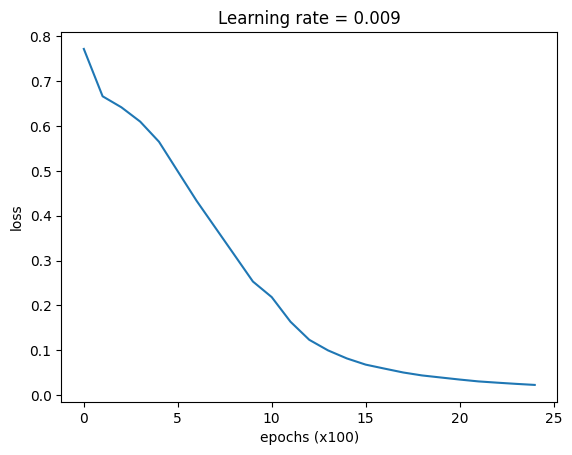

Number of trainable parameters: 258345


In [216]:
(X_train, Y_train), (X_test, Y_test), classes = load_dataset('datasets/catsvsnoncats.h5')
np.random.seed(2019)
model = deep_model(X_train, Y_train, X_test, Y_test, hidden_layers=[21, 9, 7], learning_rate=0.009)

plt.plot(model["LOSS"])
plt.ylabel('loss')
plt.xlabel('epochs (x100)')
plt.title("Learning rate = {}".format(model["LR"]))
plt.show()

params = model["PARAMS"]
parameter_count = 0
for key in params.keys():
    parameter_count = parameter_count + np.prod(params[key].shape)
print("Number of trainable parameters: {}".format(parameter_count))

> ***Expected Output:***
>
>```
> Loss after 0 epochs: 0.772
> ...
> Loss after 2200 epochs: 0.028
> Loss after 2300 epochs: 0.025
> Loss after 2400 epochs: 0.023
> 100.0% training acc.
> 78.0% test acc.
> 
> Number of trainable parameters: 258345
> ```

***

This deeper network has a little over 1/4 million parameters for a dataset of $64\times 64$ colour images. Although we did outperform our previous models, this is far from efficient. Also our model suffers from overfitting. Tuning hyper-parameters such number of hidden layers, number of units, learning rate or number of epochs also greatly affect performance of the model.

-- EOF --